In [1]:
# install required modules
import sys
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install PyPDF2
!{sys.executable} -m pip install spacy-udpipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 937.0/937.0 kB 8.9 MB/s eta 0:00:00


In [2]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/NLP4Health_Final')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from PyPDF2 import PdfReader
import re #regular expression

def extract_sdg(pdfpages):
    """
    takes a PdfReader.pages object, read the formatted ECOSOC SDG report
    returns a dictionary of texts under each SDGs
    """

    sdgs = {}
    current_sdg = 0

    new_sdg_pattern = r"\n +Goal \d+ *\."

    for page in pdfpages:
        txt = page.extract_text() # get full text
        txt = txt[30:] # remove texts from header and footer

        sdg_indexed = re.finditer(new_sdg_pattern, txt) # returns None if not found

        if bool(sdg_indexed):  # page contain new SDG
            last_sdg_index = 0
            for index in sdg_indexed:
                new_sdg_index = index.start()
                if last_sdg_index:
                    new_sdg_index -= last_sdg_index
                new_sdg_index += txt[new_sdg_index:].index("Goal") # skip the spaces

                if current_sdg > 0: # append to previous SDG
                    sdgs[current_sdg] += txt[:new_sdg_index]

                txt = txt[new_sdg_index:] # slice out the appended component

                # get the new SDG
                current_sdg = int(txt[5:txt.index(".")])
                sdgs[current_sdg] = txt

                last_sdg_index += new_sdg_index

        elif current_sdg == 0: # SDG not reached
            continue

        else: # page is a continuation of previous SDG
            sdgs[current_sdg] += txt

    return sdgs

# generate the corpus
all_sdgs = {}
for year in range(2016, 2023):
    # creating a pdf reader object
    reader = PdfReader(str(year)+'.pdf')
    # printing number of pages in pdf file
    print("Extracting", year)
    all_sdgs[year] = extract_sdg(reader.pages)
print("complete")

Extracting 2016
Extracting 2017
Extracting 2018
Extracting 2019
Extracting 2020
Extracting 2021
Extracting 2022
complete


In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import nltk
nltk.download('punkt')
import spacy_udpipe
spacy_udpipe.download("en")

nlp = spacy_udpipe.load("en")

STOPWORDS = [ # imported from R TextMining package
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was",
    "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "would", "should",
    "could", "ought", "i'm", "you're", "he's", "she's", "it's", "we're", "they're", "i've", "you've", "we've",
    "they've", "i'd", "you'd", "he'd", "she'd", "we'd", "they'd", "i'll", "you'll", "he'll", "she'll", "we'll",
    "they'll", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't", "hadn't", "doesn't", "don't", "didn't",
    "won't", "wouldn't", "shan't", "shouldn't", "can't", "cannot", "couldn't", "mustn't", "let's", "that's", "who's",
    "what's", "here's", "there's", "when's", "where's", "why's", "how's", "a", "an", "the", "and", "but", "if", "or",
    "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
    "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off",
    "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any",
    "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very"
]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Downloaded pre-trained UDPipe model for 'en' language


In [5]:
CUSTOM_STOPWORDS = ['average', 'real', 'many', 'level', 'data', 'total'] + STOPWORDS

def preprocess(text):
    doc = nlp(text)
    # Filter out tokens that are not nouns or adjectives, or are in the custom stopwords list
    processed_text = [token.lemma_ for token in doc if token.pos_ in ('NOUN', 'ADJ') and token.lemma_ not in CUSTOM_STOPWORDS]
    return processed_text

def build_graph(sentences):
    graph = defaultdict(set)
    for sentence in sentences:
        for i, word in enumerate(sentence):
            # Connect the word with words within a window of 5
            for j in range(max(i - 5, 0), min(i + 5, len(sentence) - 1) + 1):
                if i != j:
                    graph[word].add(sentence[j])
    return graph

# correct document format
df = {goal:"" for goal in range(1,18)}
for goal_number in range(1, 18):
    for year in range(2016, 2021): # replication for 2016-2020
        df[goal_number] += all_sdgs[year][goal_number]
documents = df.values()

# apply text preprocessing
processed_docs = [preprocess(doc) for doc in documents]


all_keywords = []
# apply TextRank
for i, doc in enumerate(processed_docs):
    # Split the preprocessed document into sentences
    sentences = [sent.split() for sent in nltk.tokenize.sent_tokenize(' '.join(doc))]
    # Build the graph
    graph = build_graph(sentences)
    # Use the built-in PageRank algorithm to calculate scores
    scores = nx.pagerank(nx.Graph(graph))
    # Normalize score
    min_val = min(scores.values())
    max_val = max(scores.values())
    range_val = max_val - min_val # assume non-zero
    for word, score in scores.items():
        normalized_score = (score - min_val) / range_val
        scores[word] = normalized_score

    # Sort words by score
    ranked_words = sorted(((score, word) for word, score in scores.items()), reverse=True)
    print(f"Top words for SDG {i+1} (normalized):\n{ranked_words[:10]}\n")

    # collect keywords from all documents
    all_keywords.append([(score, word) for score, word in ranked_words])

Top words for SDG 1 (normalized):
[(1.0, 'poverty'), (0.9995620391156838, 'per'), (0.9933691295167689, 'cent'), (0.8124918961395945, 'social'), (0.7086360924494641, 'country'), (0.656985819528599, 'protection'), (0.6065261049193214, 'people'), (0.5761534131325631, 'disaster'), (0.5698223561379042, 'extreme'), (0.5046932080761011, 'world')]

Top words for SDG 2 (normalized):
[(1.0, 'food'), (0.881392823633368, 'per'), (0.8683647314902978, 'cent'), (0.5932216711376184, 'hunger'), (0.4741414078044698, 'country'), (0.47152871134714736, 'agriculture'), (0.4350380271347892, 'agricultural'), (0.42976623514889856, 'insecurity'), (0.4270681720033705, 'child'), (0.4191667599710123, 'year')]

Top words for SDG 3 (normalized):
[(1.0, 'cent'), (0.96317892424601, 'per'), (0.8930417479191981, 'health'), (0.6080692444484203, 'death'), (0.49539523610247316, 'disease'), (0.48033166716445475, 'people'), (0.4386175265945157, 'country'), (0.3649365774155621, 'rate'), (0.3639869698343922, 'age'), (0.3508705

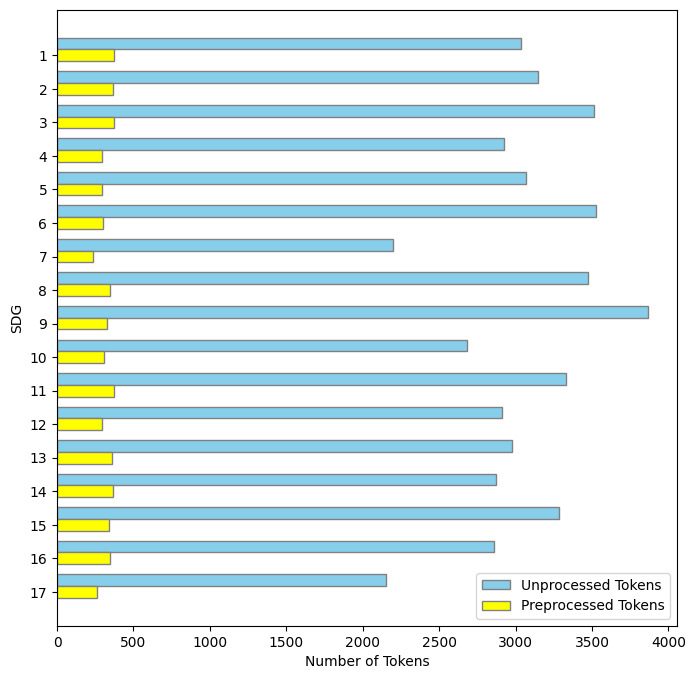

In [6]:
unprocessed_docs = [nlp(doc) for doc in documents]

# Calculate lengths
unprocessed_n = [len(tokens) for tokens in unprocessed_docs]
processed_n = [len(tokens) for tokens in all_keywords]

# Create labels for each sublist
labels = [sdg for sdg in range(1,18)]

# Create horizontal bar chart
barWidth = 0.35
r1 = np.arange(len(unprocessed_n))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(8,8))
plt.barh(r1, unprocessed_n, color='skyblue', height=barWidth, edgecolor='grey', label='Unprocessed Tokens')
plt.barh(r2, processed_n, color='yellow', height=barWidth, edgecolor='grey', label='Preprocessed Tokens')

# Label axes
plt.xlabel('Number of Tokens')
plt.ylabel('SDG')
plt.legend()

# Fix y-axis labels
plt.yticks([r + barWidth for r in range(len(unprocessed_n))], labels)
plt.gca().invert_yaxis()

# Display plot
plt.show()

In [9]:
print("Average number of tokens before preprocessing:", np.mean(unprocessed_n))
print("Average number of tokens after preprocessing:", np.mean(processed_n))
print(np.std(processed_n), min(processed_n), max(processed_n))

Average number of tokens before preprocessing: 3048.3529411764707
Average number of tokens after preprocessing: 327.1764705882353
40.75065541749013 238 375


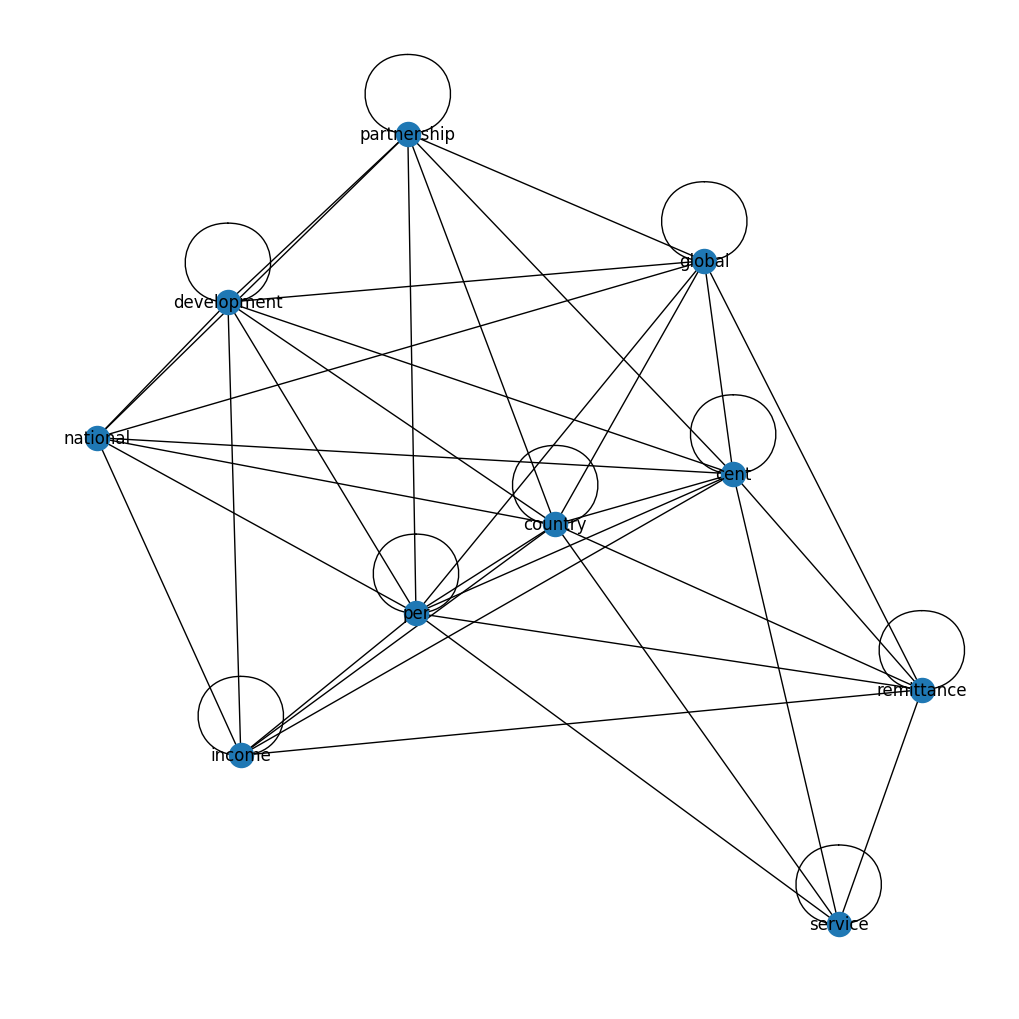

In [8]:
# Get top 10 words
top_words = [word for score, word in ranked_words[:10]]

# Create a new graph that only includes the top 10 words and the edges between them
pruned_graph = {word: {adj for adj in adjs if adj in top_words} for word, adjs in graph.items() if word in top_words}

# Draw the graph
plt.figure(figsize=(10,10))
pos = nx.spring_layout(nx.Graph(pruned_graph))  # positions for all nodes
nx.draw(nx.Graph(pruned_graph), pos, with_labels=True, font_size=12)

# show graph
plt.show()

<ipython-input-10-f4eb5928e4b2>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 17)


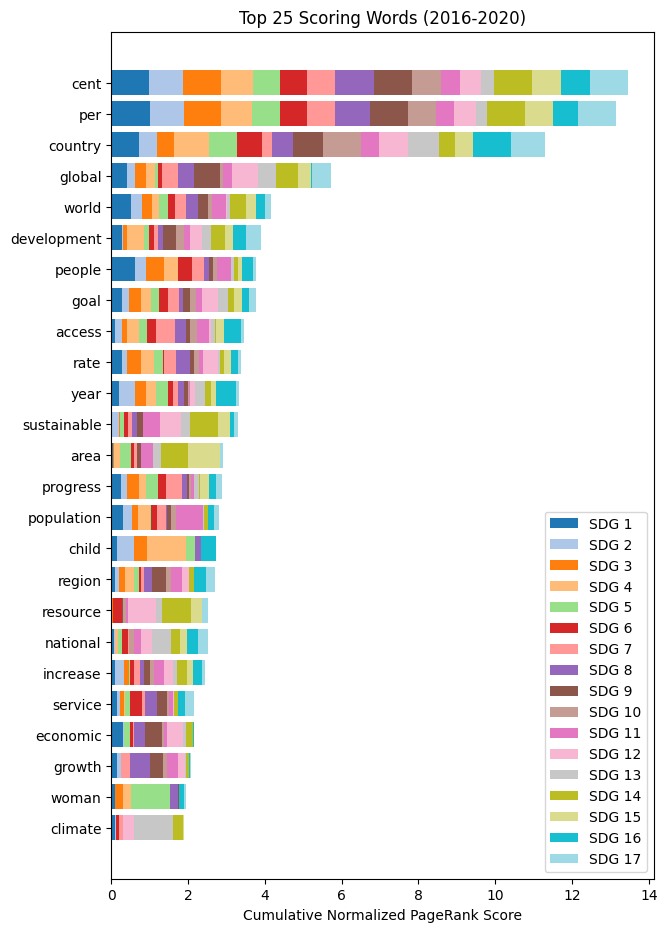

In [10]:
import numpy as np

# Initialize a dictionary to store the cumulative scores
cumulative_scores = [defaultdict(float) for _ in range(17)]

for i, list_of_tuples in enumerate(all_keywords):
    for score, word in list_of_tuples:
        cumulative_scores[i][word] += score

# Combine the cumulative scores from all lists
combined_scores = defaultdict(float)
for score_dict in cumulative_scores:
    for word, score in score_dict.items():
        combined_scores[word] += score

# Sort the words by their combined scores in descending order and take the top 25
top_words = sorted(combined_scores.items(), key=lambda item: item[1], reverse=True)[:25]

# Extract the top words into a list
top_words_list = [word for word, score in top_words]

# Get the scores for the top words in each list
scores_for_top_words = [[score_dict[word] for word in top_words_list] for score_dict in cumulative_scores]

# Create the bar plot
plt.figure(figsize=(7,10))

bottom = np.zeros(len(top_words_list))
colors = plt.cm.get_cmap('tab20', 17)

for i, scores in enumerate(scores_for_top_words):
    plt.barh(top_words_list, scores, left=bottom, color=colors(i), label=f'SDG {i+1}')
    bottom += np.array(scores)

plt.gca().invert_yaxis()
plt.xlabel('Cumulative Normalized PageRank Score')
plt.title('Top 25 Scoring Words (2016-2020)')
#plt.xlim([0,.5])
plt.legend()
plt.show()

Top words for SDG 1:
[(1.0, 'poverty'), (0.9456237793513339, 'per'), (0.9437705005008371, 'cent'), (0.7509596719265985, 'social'), (0.7300036982871826, 'country'), (0.6351987968991656, 'people'), (0.6091765546702035, 'protection'), (0.5859336230388041, 'disaster'), (0.5230752974912443, 'extreme'), (0.4390232744806609, 'world')]

Top words for SDG 2:
[(1.0, 'food'), (0.8584133054076869, 'per'), (0.8474209141679248, 'cent'), (0.5378128848165745, 'country'), (0.512116559235561, 'hunger'), (0.42937522163995695, 'year'), (0.41342651352850046, 'child'), (0.37443383795240365, 'agriculture'), (0.3495172118376199, 'agricultural'), (0.3465377783445612, 'insecurity')]

Top words for SDG 3:
[(1.0, 'health'), (0.9568655529503487, 'cent'), (0.93503591987831, 'per'), (0.6151899741393668, 'death'), (0.541463694198511, 'disease'), (0.47234556147856593, 'people'), (0.4555328242463408, 'country'), (0.4531779701580904, 'coverage'), (0.41750321981352484, 'global'), (0.4130212299590974, 'child')]

Top words

<ipython-input-13-5c1694a85c73>:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 17)


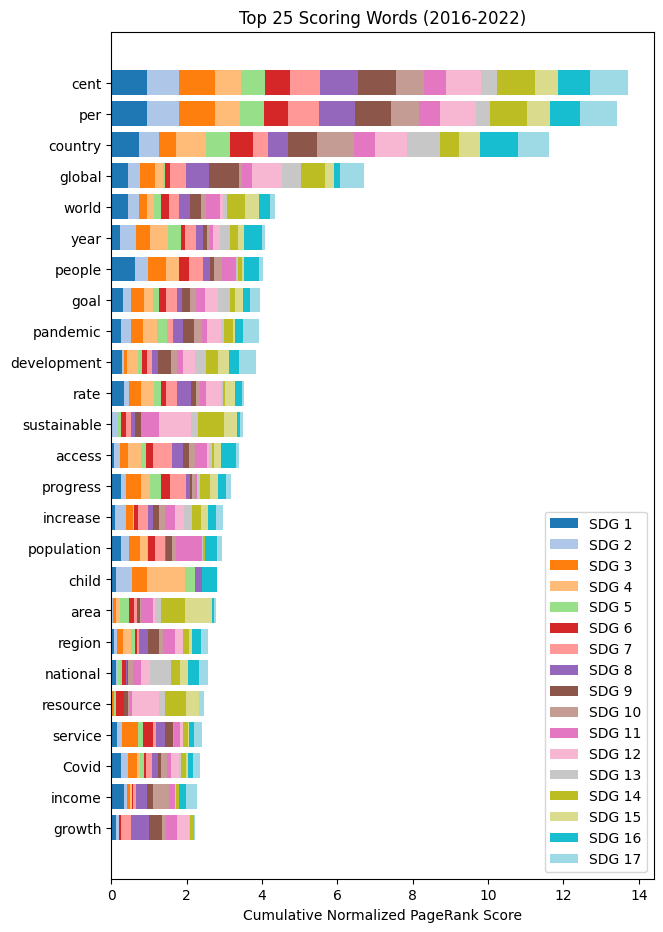

In [13]:
CUSTOM_STOPWORDS = ['average', 'real', 'many', 'level', 'data', 'total'] + STOPWORDS

# correct document format
df = {goal:"" for goal in range(1,18)}
for goal_number in range(1, 18):
    for year in range(2016, 2023):
        df[goal_number] += all_sdgs[year][goal_number]
documents = df.values()

# apply text preprocessing
processed_docs = [preprocess(doc) for doc in documents]


all_keywords = []
# apply TextRank
for i, doc in enumerate(processed_docs):
    # Split the preprocessed document into sentences
    sentences = [sent.split() for sent in nltk.tokenize.sent_tokenize(' '.join(doc))]
    # Build the graph
    graph = build_graph(sentences)
    # Use the built-in PageRank algorithm to calculate scores
    scores = nx.pagerank(nx.Graph(graph))
    # Normalize score
    min_val = min(scores.values())
    max_val = max(scores.values())
    range_val = max_val - min_val # assume non-zero
    for word, score in scores.items():
        normalized_score = (score - min_val) / range_val
        scores[word] = normalized_score
    # Sort words by score
    ranked_words = sorted(((score, word) for word, score in scores.items()), reverse=True)
    print(f"Top words for SDG {i+1}:\n{ranked_words[:10]}\n")
    # collect keywords from all documents
    all_keywords.append([(score, word) for score, word in ranked_words])

# Initialize a dictionary to store the cumulative scores
cumulative_scores = [defaultdict(float) for _ in range(17)]

for i, list_of_tuples in enumerate(all_keywords):
    for score, word in list_of_tuples:
        cumulative_scores[i][word] += score

# Combine the cumulative scores from all lists
combined_scores = defaultdict(float)
for score_dict in cumulative_scores:
    for word, score in score_dict.items():
        combined_scores[word] += score

# Sort the words by their combined scores in descending order and take the top 25
top_words = sorted(combined_scores.items(), key=lambda item: item[1], reverse=True)[:25]

# Extract the top words into a list
top_words_list = [word for word, score in top_words]

# Get the scores for the top words in each list
scores_for_top_words = [[score_dict[word] for word in top_words_list] for score_dict in cumulative_scores]

# Create the bar plot
plt.figure(figsize=(7,10))

bottom = np.zeros(len(top_words_list))
colors = plt.cm.get_cmap('tab20', 17)

for i, scores in enumerate(scores_for_top_words):
    plt.barh(top_words_list, scores, left=bottom, color=colors(i), label=f'SDG {i+1}')
    bottom += np.array(scores)

plt.gca().invert_yaxis()
plt.xlabel('Cumulative Normalized PageRank Score')
plt.title('Top 25 Scoring Words (2016-2022)')
#plt.xlim([0,.5])
plt.legend()
plt.show()

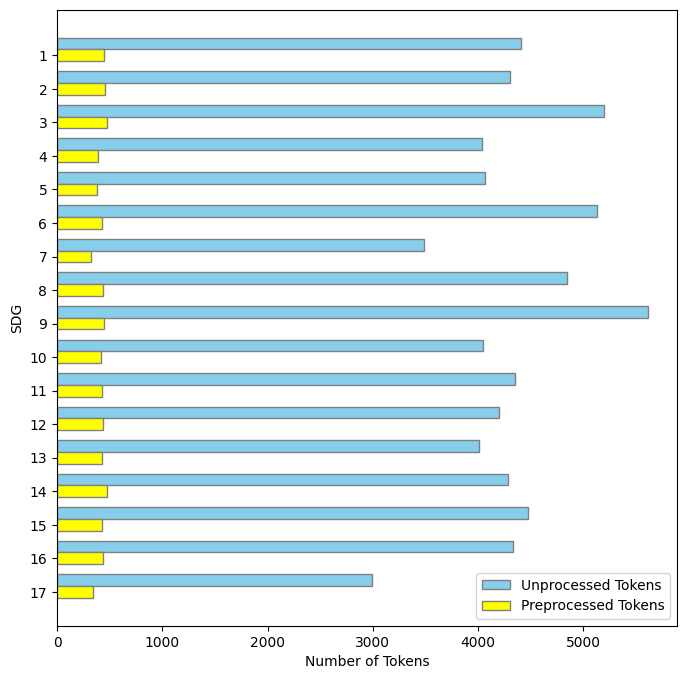

Average number of tokens before preprocessing: 4339.705882352941
602.9703694510918 2988 5609
Average number of tokens after preprocessing: 421.52941176470586
40.398191058888386 327 476


In [12]:
unprocessed_docs = [nlp(doc) for doc in documents]

# Calculate lengths
unprocessed_n = [len(tokens) for tokens in unprocessed_docs]
processed_n = [len(tokens) for tokens in all_keywords]

# Create labels for each sublist
labels = [sdg for sdg in range(1,18)]

# Create horizontal bar chart
barWidth = 0.35
r1 = np.arange(len(unprocessed_n))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(8,8))
plt.barh(r1, unprocessed_n, color='skyblue', height=barWidth, edgecolor='grey', label='Unprocessed Tokens')
plt.barh(r2, processed_n, color='yellow', height=barWidth, edgecolor='grey', label='Preprocessed Tokens')

# Label axes
plt.xlabel('Number of Tokens')
plt.ylabel('SDG')
plt.legend()

# Fix y-axis labels
plt.yticks([r + barWidth for r in range(len(unprocessed_n))], labels)
plt.gca().invert_yaxis()

# Display plot
plt.show()

print("Average number of tokens before preprocessing:", np.mean(unprocessed_n))
print(np.std(unprocessed_n), min(unprocessed_n), max(unprocessed_n))
print("Average number of tokens after preprocessing:", np.mean(processed_n))
print(np.std(processed_n), min(processed_n), max(processed_n))

# Remove "per" "cent"

Top words for SDG 1 (normalized):
[(1.0, 'poverty'), (0.8121425297283238, 'social'), (0.7231392748890586, 'country'), (0.6762615894257737, 'protection'), (0.6758401758972588, 'people'), (0.5805027674526826, 'extreme'), (0.5563149390586087, 'disaster'), (0.5468949872855207, 'world'), (0.45829579274539217, 'global'), (0.39971513639665723, 'person')]

Top words for SDG 2 (normalized):
[(1.0, 'food'), (0.6042362716481062, 'hunger'), (0.5428349950942998, 'country'), (0.4731294190965446, 'agriculture'), (0.4696275405721337, 'year'), (0.4565842483243255, 'child'), (0.4424405332413368, 'agricultural'), (0.4187642928053005, 'insecurity'), (0.3243477008223088, 'malnutrition'), (0.31902135278044697, 'world')]

Top words for SDG 3 (normalized):
[(1.0, 'health'), (0.7304605849989877, 'death'), (0.5940450176066358, 'disease'), (0.5657427070402491, 'people'), (0.5360274632662739, 'country'), (0.41560234344280916, 'age'), (0.4146082117493698, 'rate'), (0.4059559317954525, 'child'), (0.403754619176873,

<ipython-input-14-885468f6c85b>:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 17)


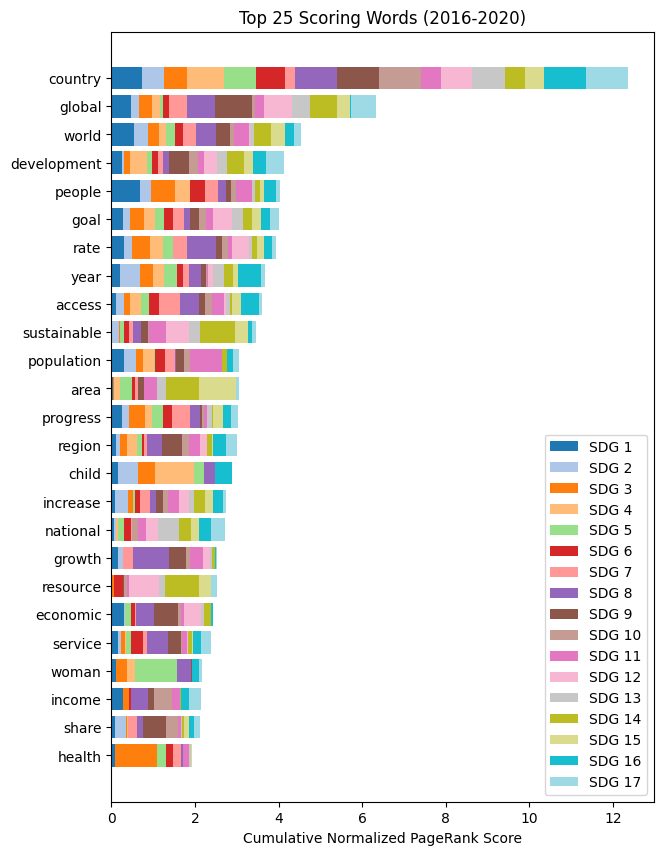

Top words for SDG 1:
[(1.0, 'poverty'), (0.7582697643605213, 'social'), (0.7470797028685788, 'country'), (0.6760521359610464, 'people'), (0.6268849834670144, 'protection'), (0.5684495345576878, 'disaster'), (0.5378235253388488, 'extreme'), (0.4745745143879316, 'global'), (0.4703051864910752, 'world'), (0.4033797819252817, 'poor')]

Top words for SDG 2:
[(1.0, 'food'), (0.5805496230112369, 'country'), (0.52501318681276, 'hunger'), (0.4724191274126963, 'year'), (0.43589144288338005, 'child'), (0.37574932180313725, 'agriculture'), (0.35463287825552053, 'agricultural'), (0.33839661309580527, 'insecurity'), (0.32913882391512156, 'age'), (0.32696877737553914, 'people')]

Top words for SDG 3:
[(1.0, 'health'), (0.6522920744120542, 'death'), (0.5746666375281893, 'disease'), (0.49887953428115644, 'country'), (0.4943869362184712, 'people'), (0.49022659569410043, 'coverage'), (0.4326295744686853, 'child'), (0.40613791389427467, 'progress'), (0.40398157417407743, 'age'), (0.4030557673320268, 'glob

<ipython-input-14-885468f6c85b>:136: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 17)


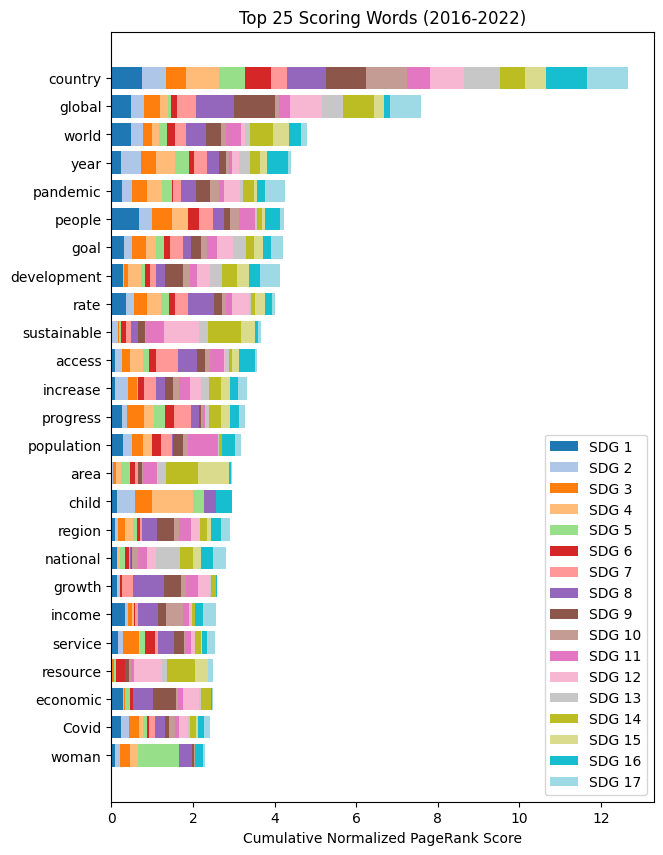

In [14]:
CUSTOM_STOPWORDS = ['average', 'real', 'many', 'level', 'data', 'total', 'per', 'cent'] + STOPWORDS

# correct document format
df = {goal:"" for goal in range(1,18)}
for goal_number in range(1, 18):
    for year in range(2016, 2021): # replication for 2016-2020
        df[goal_number] += all_sdgs[year][goal_number]
documents = df.values()

# apply text preprocessing
processed_docs = [preprocess(doc) for doc in documents]


all_keywords = []
# apply TextRank
for i, doc in enumerate(processed_docs):
    # Split the preprocessed document into sentences
    sentences = [sent.split() for sent in nltk.tokenize.sent_tokenize(' '.join(doc))]
    # Build the graph
    graph = build_graph(sentences)
    # Use the built-in PageRank algorithm to calculate scores
    scores = nx.pagerank(nx.Graph(graph))
    # Normalize score
    min_val = min(scores.values())
    max_val = max(scores.values())
    range_val = max_val - min_val # assume non-zero
    for word, score in scores.items():
        normalized_score = (score - min_val) / range_val
        scores[word] = normalized_score

    # Sort words by score
    ranked_words = sorted(((score, word) for word, score in scores.items()), reverse=True)
    print(f"Top words for SDG {i+1} (normalized):\n{ranked_words[:10]}\n")

    # collect keywords from all documents
    all_keywords.append([(score, word) for score, word in ranked_words])

# Initialize a dictionary to store the cumulative scores
cumulative_scores = [defaultdict(float) for _ in range(17)]

for i, list_of_tuples in enumerate(all_keywords):
    for score, word in list_of_tuples:
        cumulative_scores[i][word] += score

# Combine the cumulative scores from all lists
combined_scores = defaultdict(float)
for score_dict in cumulative_scores:
    for word, score in score_dict.items():
        combined_scores[word] += score

# Sort the words by their combined scores in descending order and take the top 25
top_words = sorted(combined_scores.items(), key=lambda item: item[1], reverse=True)[:25]

# Extract the top words into a list
top_words_list = [word for word, score in top_words]

# Get the scores for the top words in each list
scores_for_top_words = [[score_dict[word] for word in top_words_list] for score_dict in cumulative_scores]

# Create the bar plot
plt.figure(figsize=(7,10))

bottom = np.zeros(len(top_words_list))
colors = plt.cm.get_cmap('tab20', 17)

for i, scores in enumerate(scores_for_top_words):
    plt.barh(top_words_list, scores, left=bottom, color=colors(i), label=f'SDG {i+1}')
    bottom += np.array(scores)

plt.gca().invert_yaxis()
plt.xlabel('Cumulative Normalized PageRank Score')
plt.title('Top 25 Scoring Words (2016-2020)')
#plt.xlim([0,.5])
plt.legend()
plt.show()

# correct document format
df = {goal:"" for goal in range(1,18)}
for goal_number in range(1, 18):
    for year in range(2016, 2023):
        df[goal_number] += all_sdgs[year][goal_number]
documents = df.values()

# apply text preprocessing
processed_docs = [preprocess(doc) for doc in documents]


all_keywords = []
# apply TextRank
for i, doc in enumerate(processed_docs):
    # Split the preprocessed document into sentences
    sentences = [sent.split() for sent in nltk.tokenize.sent_tokenize(' '.join(doc))]
    # Build the graph
    graph = build_graph(sentences)
    # Use the built-in PageRank algorithm to calculate scores
    scores = nx.pagerank(nx.Graph(graph))
    # Normalize score
    min_val = min(scores.values())
    max_val = max(scores.values())
    range_val = max_val - min_val # assume non-zero
    for word, score in scores.items():
        normalized_score = (score - min_val) / range_val
        scores[word] = normalized_score
    # Sort words by score
    ranked_words = sorted(((score, word) for word, score in scores.items()), reverse=True)
    # collect keywords from all documents
    all_keywords.append([(score, word) for score, word in ranked_words])

# Initialize a dictionary to store the cumulative scores
cumulative_scores = [defaultdict(float) for _ in range(17)]

for i, list_of_tuples in enumerate(all_keywords):
    for score, word in list_of_tuples:
        cumulative_scores[i][word] += score

# Combine the cumulative scores from all lists
combined_scores = defaultdict(float)
for score_dict in cumulative_scores:
    for word, score in score_dict.items():
        combined_scores[word] += score

# Sort the words by their combined scores in descending order and take the top 25
top_words = sorted(combined_scores.items(), key=lambda item: item[1], reverse=True)[:25]

# Extract the top words into a list
top_words_list = [word for word, score in top_words]

# Get the scores for the top words in each list
scores_for_top_words = [[score_dict[word] for word in top_words_list] for score_dict in cumulative_scores]

# Create the bar plot
plt.figure(figsize=(7,10))

bottom = np.zeros(len(top_words_list))
colors = plt.cm.get_cmap('tab20', 17)

for i, scores in enumerate(scores_for_top_words):
    plt.barh(top_words_list, scores, left=bottom, color=colors(i), label=f'SDG {i+1}')
    bottom += np.array(scores)

plt.gca().invert_yaxis()
plt.xlabel('Cumulative Normalized PageRank Score')
plt.title('Top 25 Scoring Words (2016-2022)')
#plt.xlim([0,.5])
plt.legend()
plt.show()

# Unfinished Attempts to rank phrases

In [20]:
CUSTOM_STOPWORDS = ['average', 'real', 'many', 'level', 'data', 'total', "per", "cent"] + STOPWORDS

for sdg in range(1, 18):
    # Tokenize the document and filter out punctuation and spaces
    tokens = [token for token in nlp(df[sdg]) if not token.is_punct and not token.is_space and not token.is_stop and token.lemma_ not in CUSTOM_STOPWORDS]
    nodes = [token.text for token in tokens if token.pos_ in ["NOUN", "ADJ"]]


    # Initialize an undirected graph
    G = nx.Graph()
    # Add nodes to the graph
    G.add_nodes_from(nodes)
    # Create edges for words within a 5-word window
    window_size = 5

    for i in range(len(tokens) - window_size + 1):
        window = tokens[i: i + window_size]

        # Only consider windows with the relevant POS tags
        relevant_window = [token.text for token in window]

        # Create edges between each pair of words in the window
        edges = list(combinations(relevant_window, 2))

        for edge in edges:
            if G.has_edge(*edge):
                # increment weight if edge already exists
                G.edges[edge]['weight'] += 1
            else:
                # create edge with weight=1 if it does not already exist
                G.add_edge(*edge, weight=1)


    # Apply TextRank to the graph
    ranks = nx.pagerank(G)

    # Create n-grams for n from 2 to 8
    ngrams = []
    token_texts = [token.text for token in tokens if token.pos_ in ["NOUN", "ADJ"]]
    for n in range(2, 9):
        ngram_list = list(nltk.ngrams(token_texts, n))
        # Exclude n-grams with repeated words
        ngram_list = [ngram for ngram in ngram_list if all(ngram.count(word) == 1 for word in ngram)]
        ngrams.extend(ngram_list)

    # Calculate the average PageRank centrality for each n-gram
    ngram_ranks = {}
    for ngram in ngrams:
        ngram_ranks[ngram] = sum(ranks.get(word, 0) for word in ngram) / len(ngram)

    # Combine n-gram (phrases) and nodes (words) to generate ranking
    ranks.update(ngram_ranks)
    # Normalize the scores
    min_val = min(ranks.values())
    max_val = max(ranks.values())
    range_val = max_val - min_val # assume non-zero
    for phrase, score in ranks.items():
        normalized_score = (score - min_val) / range_val
        ranks[phrase] = normalized_score

    combined_ranks = {}
    for token, rank in ranks.items():
        if type(token) is tuple:
          combined_ranks[" ".join(token)] = rank
        else:
          combined_ranks[token] = rank


<ipython-input-21-a3a740ff7f74>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 17)


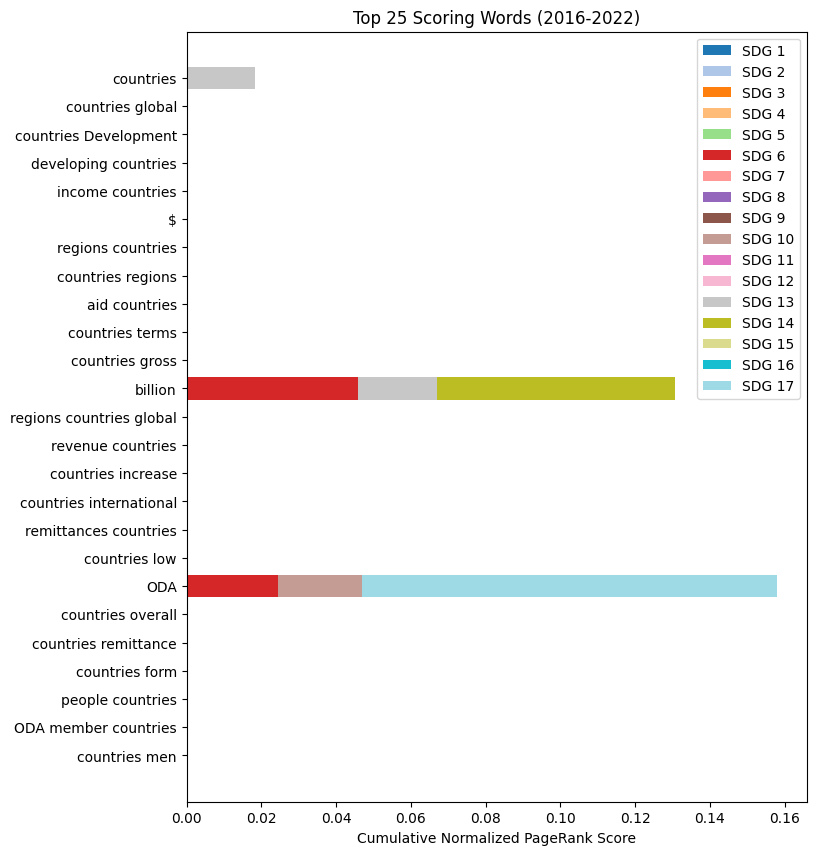

In [21]:
# Sort the phrases by their combined scores in descending order and take the top 25
top_phrases = sorted(combined_ranks.items(), key=lambda item: item[1], reverse=True)[:25]

# Extract the top phrases into a list
top_phrases_list = [phrase for phrase, score in top_phrases]

# Get the scores for the top phrases in each list
scores_for_top_phrases = [[score_dict[phrase] for phrase in top_phrases_list] for score_dict in cumulative_scores]

# Create the bar plot
plt.figure(figsize=(8,10))

bottom = np.zeros(len(top_phrase_list))
colors = plt.cm.get_cmap('tab20', 17)

for i, scores in enumerate(scores_for_top_phrases):
    plt.barh(top_phrase_list, scores, left=bottom, color=colors(i), label=f'SDG {i+1}')
    bottom += np.array(scores)

plt.gca().invert_yaxis()
plt.xlabel('Cumulative Normalized PageRank Score')
plt.title('Top 25 Scoring Phrases (2016-2022)')
#plt.xlim([0,.5])
plt.legend()
plt.show()